

# Portfolio Management-Market Volatility and Risk Appetite

The goal of this case study is to build a machine learning
model to predict whether a person is likely to change the risk appetite with the
change in the market situation. The purpose is also to identify the factors the cause people to change their risk appetite. 


## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Data Preparation and Feature Selection](#2)
    * [3.1. Preparing the predicted variable](#2.1)    
    * [3.2. Feature Selection-Limit the Feature Space](#2.2)
* [4.Evaluate Algorithms and Models](#4)        
    * [4.1. Train/Test Split](#4.1)
    * [4.2. Test Options and Evaluation Metrics](#4.2)
    * [4.3. Compare Models and Algorithms](#4.3)
* [5. Model Tuning and Grid Search](#5)  
* [6. Finalize the Model](#6)  
    * [6.1. Results on test dataset](#6.1)
* [7 Feature Analysis](#7)
    * [7.1. Feature Importance](#7.1)
    * [7.2. Feature Intuition](#7.2)


<a id='0'></a>
# 1. Problem Definition

This case study uses a classification-based model to predict whether a person is likely
to change the risk aversion with the change in the market situation not.


For this case study the data used is from survey of Consumer Finances which is conducted by the Federal Reserve
Board. The data source is : 
https://www.federalreserve.gov/econres/scf_2009p.htm


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [3]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

Using TensorFlow backend.


<a id='1.2'></a>
## 2.2. Loading the Data

In [4]:
# load dataset
dataset = pd.read_excel('SCFP2009panel.xlsx')

In [7]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [158]:
type(dataset)

pandas.core.frame.DataFrame

In [159]:
dataset.shape

(19285, 35)

<a id='2'></a>
## 3. Data Preparation and Feature Selection

<a id='2.1'></a>
## 3.1. Preparing the predicted variable

The dataset from "Survey of Consumer Finances" contains the Household's demographics, net worth, financial and non-financial assets for the same demographics in 2007 (pre-crisis) and 2009(post-crisis). 

The data can be used to get the implied Risk Aversion for the household from the Household's demographics, net worth, financial and non-financial assets as per _Schooley and Worden (1996) (Risk Aversion Measures: Comparing Attitudes and Asset Allocation. Financial Services Review. 5 (2): 87-99) and is shown below:_ 

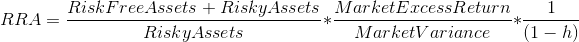

* **Risky assets** is investments in mutual funds, stocks, bonds, commodities, and
real estate, and an estimate of human capital. 
* **Risk Free Assets**: checking and savings balances,certificates of deposit, and other cash balances and equivalents.
* **Ratio of MarketExcessReturn to Variance**: This is similar to sharp ratio is constant among all the market participants.
* **h**: It is the ratio of human capital to total wealth.To compute human capital people are assumed to work until they are 65, their incomes increase by 3% annually and the average interest rate is 5% based on 10 year treasury yields during 2007. Since this is a long term measure. We define wealth as the sum of risky and risk-free assets



In [8]:
dataset['UntilRetire07'] = dataset['AGE07'].apply(lambda x: max((70 - x),0))
dataset['Multiplier07'] = dataset['UntilRetire07'].apply(lambda x: ((pow(1.07,x) - 1)/(0.05)))

dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['HumanCap07'] = dataset['Multiplier07']*dataset['INCOME07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] + dataset['HumanCap07']
dataset['Alpha07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])
dataset['h07'] = dataset['HumanCap07']/(dataset['HOUSES07'] + dataset['Risky07']+dataset['RiskFree07'])
dataset['CValue07'] = 0.45/((1-dataset['h07'])*(dataset['Alpha07']))

dataset['UntilRetire09'] = dataset['AGE07'].apply(lambda x: max((70 - x),0))
dataset['Multiplier09'] = dataset['UntilRetire07'].apply(lambda x: ((pow(1.07,x) - 1)/(0.05)))

dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['HumanCap09'] = dataset['Multiplier09']*dataset['INCOME09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] + dataset['HumanCap09']
dataset['Alpha09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])
dataset['h09'] = dataset['HumanCap09']/(dataset['HOUSES09'] + dataset['Risky09']+dataset['RiskFree09'])
dataset['CValue09'] = 0.45/((1-dataset['h09'])*(dataset['Alpha09']))
dataset['PercentageChange'] = dataset['CValue09']/dataset['CValue07']-1

The predicted variable is the degree of percentage change in Risk Aversion between 2007 and 2009, and is defined as follows:
* Change > 75%  = 1
* Change <-.75% = -1
* -75% < Change > 75% = 0

In [9]:
dataset['ChangeRiskAversion'] = np.where(dataset['PercentageChange'] > .75, 1.0, (np.where(dataset['PercentageChange'] < -.75,-1,0)))

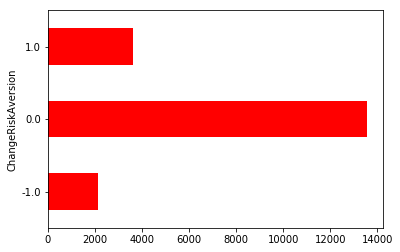

In [10]:
fig = plt.figure()
plot = dataset.groupby(['ChangeRiskAversion']).size().plot(kind='barh', color='red')
plt.show()

In [11]:
dataset['ChangeRiskAversion'].value_counts(normalize=True, dropna=False)

 0.0    0.702411
 1.0    0.187088
-1.0    0.110500
Name: ChangeRiskAversion, dtype: float64

About 70% of the People didn't change the risk aversion, however, around 18% increased their risk aversion and 11% decreased the risk aversion by more than 75%. 

<a id='2.2'></a>
## 3.2. Feature Selection-Limit the Feature Space 

In [12]:
dataset.shape

(19285, 533)

In [13]:
# types
set_option('display.max_rows', 500)
#dataset.dtypes

YY1                     int64
Y1                      int64
WGT09                 float64
AGE07                   int64
AGECL07                 int64
EDUC07                  int64
EDCL07                  int64
MARRIED07               int64
KIDS07                  int64
LIFECL07                int64
FAMSTRUCT07             int64
RACECL                  int64
H_RACECL                int64
RACE                    int64
H_RACE                  int64
OCCAT107                int64
OCCAT207                int64
INDCAT07                int64
HHEALTH07               int64
SPHEALTH07              int64
INCOME07              float64
WAGEINC07             float64
BUSSEFARMINC07        float64
INTDIVINC07           float64
KGINC07               float64
SSRETINC07            float64
TRANSFOTHINC07        float64
PENACCTWD07             int64
NORMINC07             float64
RISK07                  int64
PSAVING07             float64
WSAVED07                int64
SAVED07                 int64
SAVRES1   

<a id='2.2.2'></a>
### 3.2.2.  Features elimination

In order to filter the features further we do the following:
1. Check the description in the Data Dictionary (https://www.federalreserve.gov/econres/files/codebk2009p.txtand only keep the features that are intuitive based on subjective judgement
The description of the factors is as follows: 
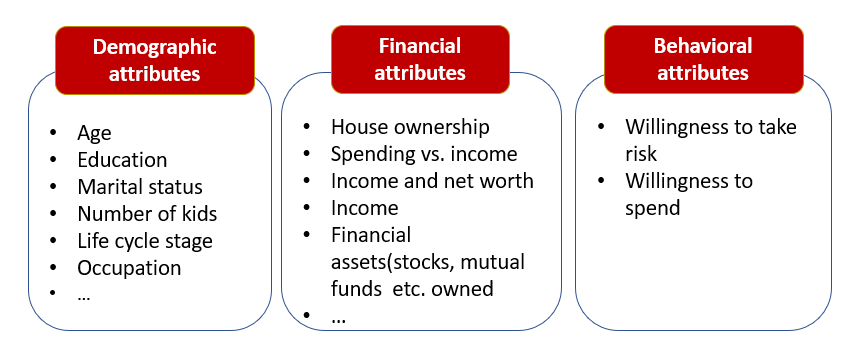


2. Keep only the intuitive factors as of 2007 only and remove all the intermediate features and features related to 2009, as the variables of 2007 are the only ones required for predicting a change in the risk tolerance.


In [14]:
keep_list = ['ChangeRiskAversion','AGE07', 'AGECL07', 'EDCL07', 'MARRIED07', 'KIDS07', 'LIFECL07', 'OCCAT107', 'INCOME07', 'NORMINC07', 'RISK07', 'WSAVED07', 'SAVED07', 'SPENDMOR07', 'LIQ07', 'CDS07', 'NMMF07', 'STOCKS07', 'BOND07', 'RETQLIQ07', 'SAVBND07','CASHLI07', 'OTHMA07', 'OTHFIN07', 'FIN07', 'ORESRE07', 'NNRESRE07', 'OTHNFIN07', 'NFIN07', 'NHNFIN07', 'HOUSES07', 'ASSET07', 'HOMEEQ07', 'DEBT07', 'NETWORTH07', 'RISK07']
len(keep_list)

36

In [15]:
drop_list = [col for col in dataset.columns if col not in keep_list]

dataset.drop(labels=drop_list, axis=1, inplace=True)

dataset.shape

(19285, 35)

In [16]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [17]:
# Drop the rows containing NA
dataset=dataset.dropna(axis=0)
dataset=dataset.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
dataset.shape

(19285, 35)

<a id='4'></a>
# 4. Evaluate Algorithms and Models

<a id='4.1'></a>
## 4.1. Train Test Split

In [40]:
# split out validation dataset for the end
Y= dataset["ChangeRiskAversion"]
X = dataset.loc[:, dataset.columns != 'ChangeRiskAversion']
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(rescaledX, Y, test_size=validation_size, random_state=seed)

In [20]:
dataset['ChangeRiskAversion'].value_counts()

 0.0    13546
 1.0     3608
-1.0     2131
Name: ChangeRiskAversion, dtype: int64

<a id='4.2'></a>
## 4.2. Test Options and Evaluation Metrics


In [160]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 4.3. Compare Models and Algorithms

### Classification Models

In [285]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### K-folds cross validation

In [286]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.703980 (0.007770)
LDA: 0.703591 (0.007521)
KNN: 0.846317 (0.011164)
CART: 0.929543 (0.006309)
NB: 0.237749 (0.009657)
NN: 0.783250 (0.008020)
AB: 0.716036 (0.010712)
GBM: 0.770677 (0.010944)
RF: 0.949766 (0.005895)


In [50]:
### Algorithm comparison

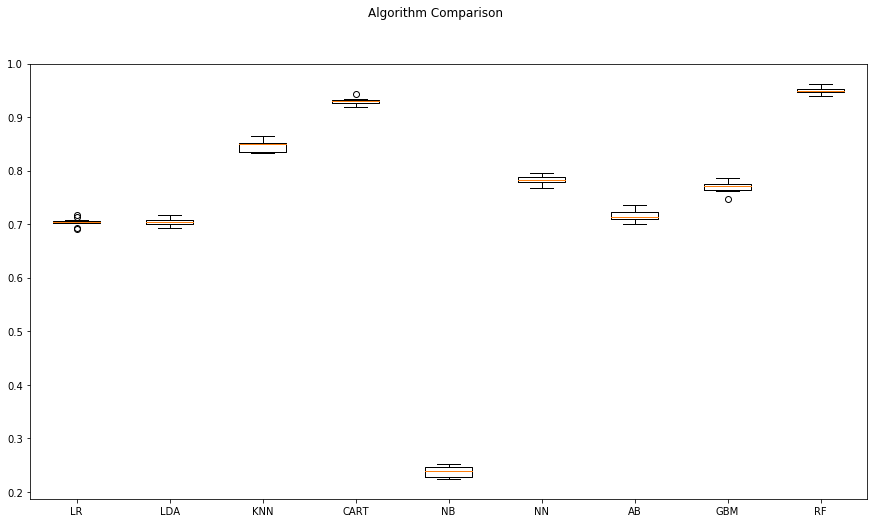

In [287]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

<a id='5'></a>
# 5. Model Tuning and Grid Search

Given that the Random Forest is the best model, Grid Search is performed on Random Forest.

In [288]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
n_estimators = [20,80,200]
max_depth= [5,100]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.958971 using {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 80}
#7 0.713508 (0.008355) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#10 0.709684 (0.007648) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#9 0.710202 (0.007921) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 200}
#5 0.955795 (0.003819) with: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 20}
#1 0.958971 (0.004656) with: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 80}
#2 0.958582 (0.005108) with: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 200}
#8 0.711174 (0.009196) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#11 0.708582 (0.007772) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#12 0.706961 (0.008451) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 200}
#6 0.954952 (0.005331) with: {'criterion': 'entropy', 'max_depth': 100, 'n_estimators': 20}
#4 0.958128 (0.004774) 

<a id='6'></a>
# 6. Finalise the Model

Let us test the model on the test dataset and look at feature importance in this step

<a id='6.1'></a>
## 6.1. Results on the Test Dataset

In [21]:
# prepare model
model = RandomForestClassifier(criterion='gini', max_depth= 100, n_estimators= 80,n_jobs=-1)
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [22]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9585169821104486
[[ 442   25    0]
 [  17 2621   45]
 [   0   73  634]]
              precision    recall  f1-score   support

        -1.0       0.96      0.95      0.95       467
         0.0       0.96      0.98      0.97      2683
         1.0       0.93      0.90      0.91       707

    accuracy                           0.96      3857
   macro avg       0.95      0.94      0.95      3857
weighted avg       0.96      0.96      0.96      3857



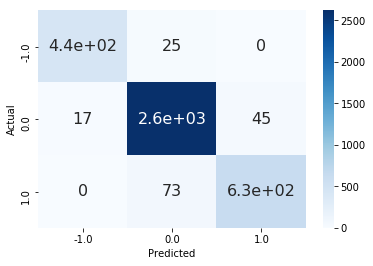

In [23]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

From the confusion matrix shown above, the random forest algorithm predicts both the classes of 1 and -1 where the investors change the risk aversion quite accurately. The overall accuracy of the test set is above 95%.


<a id='7'></a>
# 7. Feature Importance and Features Intuition

<a id='7.1'></a>
## 7.1. Feature Importance
Looking at the details above Random forest be worthy of further study.
Let us look into the Feature Importance of the RF model

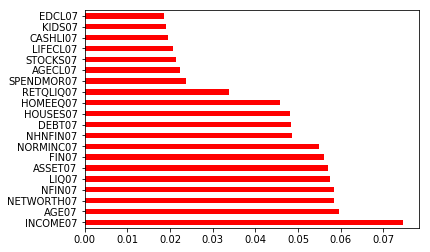

In [156]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

feat_importances.nlargest(20).plot(kind='barh',color='r' )
plt.show()

Age, income and net-worth come out to be the three most important factors which is a
quite intuitive and meaningful outcome

<a id='7.2'></a>
## 7.2. Feature Intuition

Analysing the important features

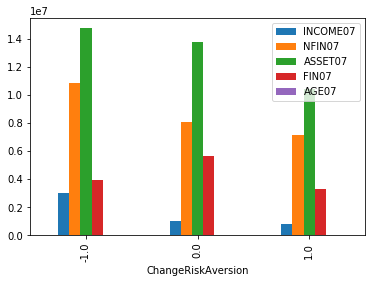

In [138]:
dataset.groupby('ChangeRiskAversion').mean()[['INCOME07','NFIN07','ASSET07','FIN07']].plot.bar()

It is clear from the chart above that the investors who had lower income and asset become more risk averse, and the investors who had higher income had decreased risk aversion.

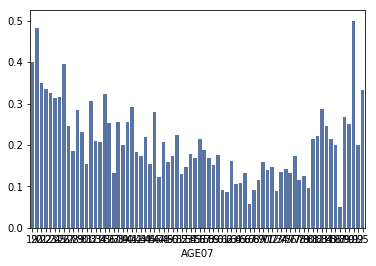

In [74]:
charge_off_rates = dataset.groupby('AGE07')['ChangeRiskAversion'].value_counts(normalize=True).loc[:,1]
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)

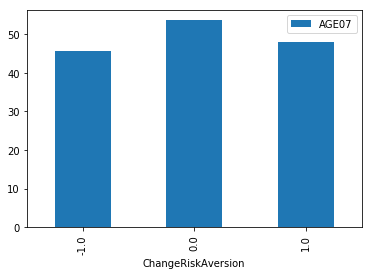

In [139]:
dataset.groupby('ChangeRiskAversion').mean()[['AGE07']].plot.bar()

In [155]:
dataset.groupby('AGECL07')['ChangeRiskAversion'].value_counts(normalize=True).loc[:,-1]

AGECL07
1    0.191597
2    0.129609
3    0.118354
4    0.087112
5    0.044259
6    0.056970
Name: ChangeRiskAversion, dtype: float64

The change in risk aversion changes with the age and people and people with relatively younger age change their risk appetite. Also, for the change to -1, people who became more risk takers after crisis period were younger people. 

__Conclusion__:

We demonstrated the fact that machine learning
models might be able to objectively analyze the behavior of different investors with
the change in market and attribute these changes to variables involved in determining
risk appetite.

In the data preparation step, we illustrated the importance of
data reduction step and demonstrate how can we achieve the feature elimination
when there is a large number of features.

Finally, we analyzed the feature importance and found that results of the case study
are quite meaningful and provided a good insight into the investor behavior with
changing market situation. The investors who had lower income and asset become
more risk averse, and the investors who had higher income had decreased risk aver‐
sion. The change in risk aversion changes with the age and individuals and individu‐
als with relatively younger age change their risk appetite. Such feature analysis
provides us deeper qualitative insight into a machine learning model.


